The goal here is to identify a good core set of features to use in other tasks, like clustering, decision trees, and neural networks. It would be possible to group all proposed features together, even using an automated process such as feature agglomeration. However, this offends our sensibilities that features should be interpretable. What can we do to get a picture of what features are useful? Or even how many features to choose? This is a rough, exploratory procedure, but it gives us a starting point.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import sys
sys.path.append('/depot/tdm-musafe/apps')
from make_features import load_data

%matplotlib widget

In [2]:
incidents, acceleration = load_data(drop_batches = False)

In [3]:
features = pd.read_csv('/depot/tdm-musafe/data/features.csv', index_col = 'incident_id').loc[incidents.index]
features.drop(inplace = True, columns = [col for col in features.columns if col.startswith('window')])

First, rescale each feature to have zero mean and unit variance. Then, find the eigenvalues of the covariance matrix.

In [4]:
from sklearn.preprocessing import StandardScaler
f = StandardScaler().fit_transform(features)
w = np.linalg.eigvals(np.cov(f.T))

There is a rule of thumb that the number of features we should keep is related to the number of eigenvalues greater than 1. We can make a so-called "scree plot" showing the distribution of eigenvalues.

In [5]:
components = (w > 1).sum()
components

7

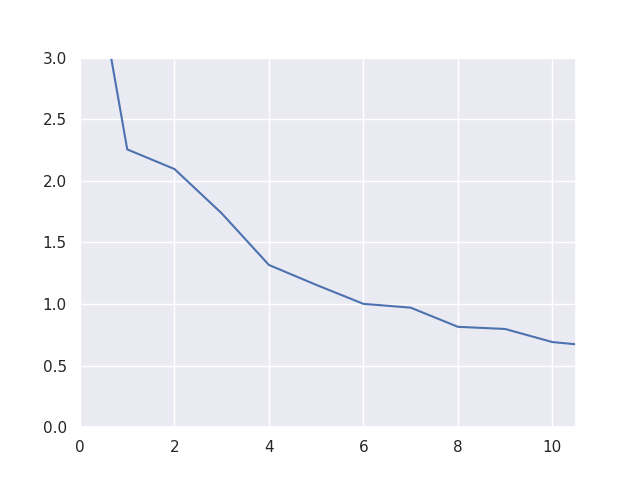

In [15]:
fig, ax = plt.subplots()
ax.plot(np.sort(w)[::-1]guesses = acc_model.predict(X2)

sns.scatterplot(x=guesses, y=Y)
plt.show())
ax.set_xlim(xmin = 0, xmax=components*1.5)
ax.set_ylim(ymin = 0, ymax=3)
plt.show()

In [7]:
from sklearn.decomposition import FactorAnalysis

In [8]:
fact = FactorAnalysis(n_components = components, rotation='varimax').fit(f)

To make it easier to distinguish the factors, let's scale them so their largest component is 1, changing sign if necessary.

In [9]:
scale = np.diag(fact.components_.T[abs(fact.components_).argmax(axis=1)])
loadings = pd.DataFrame((fact.components_.T / scale).T, columns = features.columns)

In [10]:
display(loadings.style.background_gradient(axis='columns', cmap = 'RdYlGn', vmin=-1, vmax=1))

,maximum,minimum,mean,variance,skew,kurtosis,mean x,mean y,mean z,peak x,peak y,peak z,stillness,middle of stillness,angular path length,biggest angle difference,angle between incident and vertical,low frequency power,medium frequency power,high frequency power
0,0.185925,0.555500,-0.332526,-0.397703,1.000000,0.975027,0.015455,0.041507,0.176558,-0.001652,0.024951,0.051438,-0.398289,0.052948,-0.002695,0.011682,0.057798,-0.200867,-0.437126,-0.110690
1,0.733050,-0.209176,0.799133,1.000000,-0.158779,-0.247455,0.038864,-0.016837,-0.262286,0.064912,-0.002147,-0.293870,0.155504,-0.045647,0.017326,0.021715,-0.061009,0.948971,0.420450,0.015125
2,0.018515,0.010225,-0.161015,0.034385,0.050949,0.020800,0.310513,1.000000,0.311131,0.086403,0.939719,0.134637,-0.004250,-0.019466,-0.029749,-0.042162,-0.088541,0.004861,-0.005464,-0.099548
3,0.021701,-0.094806,-0.029221,-0.010265,0.009783,0.004251,0.131721,-0.059874,0.185291,0.115487,-0.019016,-0.025986,-0.139821,0.052258,1.000000,0.990318,0.055053,0.084315,-0.073911,0.019349
4,0.044176,0.204929,0.003388,-0.064775,0.019049,0.004570,0.008826,0.046569,-0.035738,0.122383,-0.170898,-0.369425,0.041059,-0.007738,0.034413,0.020484,1.000000,-0.015030,-0.133838,0.125963
5,-0.118833,-0.487671,0.131751,0.566005,-0.175577,0.085704,0.041528,-0.012894,-0.048892,-0.101819,-0.006562,0.208800,0.611870,-0.023183,-0.084570,0.047060,-0.025353,-0.397227,1.000000,0.755284
6,-0.559671,0.644436,1.000000,0.047154,-0.127912,-0.038794,0.106058,-0.034373,-0.295103,0.094736,-0.032864,0.002084,0.223874,-0.034450,-0.060991,0.031412,0.017138,-0.071898,-0.037674,0.211334


We can see a few features are mostly redundant. Here are a few contenders:
- Skew and kurtosis tell us the same information; we should discard kurtosis.
- Angular path length and biggest-angle-difference are repeating one another. We should discard biggest-angle-difference.
- Mean y and peak y carry the same information. One of them should be discarded -- likely the peak, since that is more heavily loaded with other factors.

This also gives us a suggestion for a reduced feature set of just seven features:

In [11]:
loadings.idxmax(axis='columns')

0                                   skew
1                               variance
2                                 mean y
3                    angular path length
4    angle between incident and vertical
5                 medium frequency power
6                                   mean
dtype: object

We may as well combine medium and high frequency power, since it makes physical sense to add them and they contribute toward the same factor. That gives us a good core set of features to build upon.